# Anomaly Detection with classifier guidance

This tutorial illustrates how to use MONAI for training a 2D gradient-guided anomaly detection using DDIMs [1].


[1] - Wolleb et al. "Diffusion Models for Medical Anomaly Detection" https://arxiv.org/abs/2203.04306


TODO: Add Open in Colab

## Setup environment

In [3]:
!python /home/juliawolleb/PycharmProjects/MONAI/GenerativeModels/setup.py install
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import seaborn" || pip install -q seaborn
%matplotlib inline

running install
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
writing generative.egg-info/PKG-INFO
writing dependency_links to generative.egg-info/dependency_links.txt
writing requirements to generative.egg-info/requires.txt
writing top-level names to generative.egg-info/top_level.txt
reading manifest file 'generative.egg-info/SOURCES.txt'
writing manifest file 'generative.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib

creating build/bdist.linux-x86_64/egg
creating buil

## Setup imports

In [4]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
import os
import shutil
import tempfile
import time
import os
import matplotlib.pyplot as plt
import seaborn
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import MedNISTDataset, DecathlonDataset
from monai.config import print_config
from monai.data import CacheDataset, DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from generative.inferers import DiffusionInferer

# TODO: Add right import reference after deployed
from generative.networks.nets.diffusion_model_unet import DiffusionModelUNet, DiffusionModelEncoder

from generative.networks.schedulers.ddpm import DDPMScheduler
from generative.networks.schedulers.ddim import DDIMScheduler
print_config()




ZipImportError: bad local file header: '/home/juliawolleb/anaconda3/envs/experiment/lib/python3.10/site-packages/generative-0.1.0-py3.10.egg'

## Setup data directory

In [14]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
#root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir='/home/juliawolleb/PycharmProjects/MONAI/data_brats'

print(root_dir)

/home/juliawolleb/PycharmProjects/MONAI/data_brats


## Set deterministic training for reproducibility

In [15]:
set_determinism(42)

## Setup BRATS Dataset for 2D slices  and training and validation dataloaders
As baseline, we use the load_2d_brats.ipynb written by Pedro in issue 150

In [ ]:


batch_size = 2
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image","label"]),
        transforms.EnsureChannelFirstd(keys=["image","label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image","label"]),
        transforms.Orientationd(keys=["image","label"], axcodes="RAS"),
        transforms.Spacingd(
            keys=["image","label"],
            pixdim=(3.0, 3.0, 2.0),
            mode=("bilinear", "nearest"),
        ),
        transforms.CenterSpatialCropd(keys=["image","label"], roi_size=(64, 64, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: (x.reshape(x.shape[0], -1, x.shape[-1]).sum(1) > 0 ).float().squeeze()),
    ]
)
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
nb_3D_images_to_mix = 2
train_loader_3D = DataLoader(train_ds, batch_size=nb_3D_images_to_mix, shuffle=True, num_workers=4)
print(f'Image shape {train_ds[0]["image"].shape}')








Task01_BrainTumour.tar:  71%|█████████▉    | 5.03G/7.09G [04:43<01:46, 20.8MB/s]

In [13]:

val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",  # validation
    cache_rate=0.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasnt been downloaded yet
    seed=0,
    transform=train_transforms,
)
val_loader_3D = DataLoader(val_ds, batch_size=nb_3D_images_to_mix, shuffle=True, num_workers=4)
print(f'Image shape {val_ds[0]["image"].shape}')



2023-02-02 10:39:45,467 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2023-02-02 10:39:45,469 - INFO - File exists: /tmp/tmpyurp7egh/Task01_BrainTumour.tar, skipped downloading.
2023-02-02 10:39:45,471 - INFO - Non-empty folder exists in /tmp/tmpyurp7egh/Task01_BrainTumour, skipped extracting.
Image shape torch.Size([1, 64, 64, 64])


Here we use transforms to augment the training dataset, as usual:

1. `LoadImaged` loads the hands images from files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `ScaleIntensityRanged` extracts intensity range [0, 255] and scales to [0, 1].
1. `RandAffined` efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.



### Visualisation of the training images

Batch shape: torch.Size([128, 1, 64, 64])
Slices class: tensor([0., 0., 0., 1.])


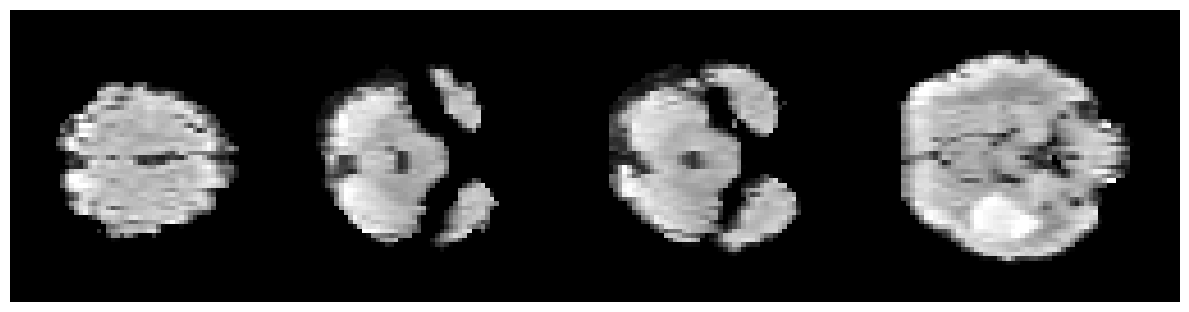

In [47]:


from typing import Dict
def get_batched_2d_axial_slices(data : Dict):
    images_3D = data['image']
    batched_2d_slices = torch.cat(images_3D.split(1, dim = -1), 0).squeeze(-1) # images_3D.view(images_3D.shape[0]*images_3D.shape[-1],*images_3D.shape[1:-1])
    slice_label = data['slice_label']
    #slice_label = (mask_label.reshape(mask_label.shape[0], -1, mask_label.shape[-1]).sum(1) > 0 ).float()
    slice_label = torch.cat(slice_label.split(1, dim = -1),0).squeeze()
    return batched_2d_slices, slice_label

check_data = first(train_loader_3D)
batched_2d_slices, slice_label = get_batched_2d_axial_slices(check_data)
idx = list(torch.randperm(batched_2d_slices.shape[0]))
slices = [0,30,45,63]
print(f"Batch shape: {batched_2d_slices.shape}")
print(f"Slices class: {slice_label[idx][slices].view(-1)}")
image_visualisation = torch.cat(batched_2d_slices[idx][slices].squeeze().split(1), dim=2).squeeze()
plt.figure("training images", (12, 6))
plt.imshow(image_visualisation, vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

In [48]:

subset_2D = zip(batched_2d_slices.split(batch_size),slice_label.split(batch_size))#
a,b = next(subset_2D)  #what is a, what is b? Are these the next images? 
a.shape, b.shape

(torch.Size([2, 1, 64, 64]), torch.Size([2]))

### Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDPM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the original DDPM scheduler containing 1000 timesteps in its Markov chain, and a 2D UNET with attention mechanisms
in the 3rd level, each with 1 attention head (`num_head_channels=64`).

In order to pass conditioning variables with dimension of 1 (just specifying the modality of the image), we use:

`
with_conditioning=True,
cross_attention_dim=1,
`

In [49]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
  #  cross_attention_dim=1,
)
model.to(device)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

### Model training of the Diffusion Model
Here, we are training our diffusion model for 75 epochs (training time: ~50 minutes).

In [50]:
n_epochs = 2
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []


scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(subset_2D), total=len(idx), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, (a,b) in progress_bar:
        print('step', step, a.shape, b.shape, b)
       
        images = a.to(device)
        print('image', images.shape)
        classes = b.to(device)
        print('classes', classes)
        optimizer.zero_grad(set_to_none=True)
        timesteps = torch.randint(0, 1000, (len(images),)).to(device)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)  #remove the class conditioning

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            classes = batch["class"].to(device)
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)#torch.from_numpy(np.arange(0, 1000)[::-1].copy())

            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(device)
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix(
                {
                    "val_loss": val_epoch_loss / (step + 1),
                }
            )
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 0:   1%|            | 1/128 [00:00<00:16,  7.89it/s, loss=0.982]

step 0 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 1 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:   2%|▍               | 3/128 [00:00<00:13,  9.55it/s, loss=1]

step 2 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 3 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 4 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:   5%|▋           | 7/128 [00:00<00:11, 10.26it/s, loss=0.992]

step 5 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 6 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 7 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:   7%|▊           | 9/128 [00:00<00:11, 10.38it/s, loss=0.988]

step 8 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 9 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 10 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  10%|█          | 13/128 [00:01<00:10, 10.52it/s, loss=0.981]

step 11 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 12 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 13 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')


Epoch 0:  12%|█▎         | 15/128 [00:01<00:10, 10.51it/s, loss=0.978]

step 14 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')
step 15 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')
step 16 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')


Epoch 0:  15%|█▋         | 19/128 [00:01<00:10, 10.65it/s, loss=0.971]

step 17 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')
step 18 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')
step 19 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')


Epoch 0:  16%|█▊         | 21/128 [00:02<00:10, 10.22it/s, loss=0.968]

step 20 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')
step 21 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')


Epoch 0:  18%|█▉         | 23/128 [00:02<00:10,  9.82it/s, loss=0.964]

step 22 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')
step 23 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')


Epoch 0:  20%|██▏        | 25/128 [00:02<00:10,  9.50it/s, loss=0.961]

step 24 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')
step 25 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')


Epoch 0:  21%|██▎        | 27/128 [00:02<00:10,  9.34it/s, loss=0.956]

step 26 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([1., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([1., 1.], device='cuda:0')
step 27 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 1.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 1.], device='cuda:0')


Epoch 0:  23%|██▍        | 29/128 [00:02<00:10,  9.18it/s, loss=0.953]

step 28 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 29 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  24%|██▋        | 31/128 [00:03<00:10,  9.21it/s, loss=0.949]

step 30 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 31 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  26%|██▊        | 33/128 [00:03<00:10,  9.20it/s, loss=0.944]

step 32 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 33 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  27%|███▎        | 35/128 [00:03<00:10,  9.12it/s, loss=0.94]

step 34 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 35 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  29%|███▏       | 37/128 [00:03<00:10,  9.07it/s, loss=0.934]

step 36 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 37 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  30%|███▎       | 39/128 [00:04<00:09,  9.09it/s, loss=0.929]

step 38 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 39 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  32%|███▌       | 41/128 [00:04<00:09,  9.15it/s, loss=0.925]

step 40 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 41 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  34%|███▋       | 43/128 [00:04<00:09,  9.17it/s, loss=0.921]

step 42 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 43 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  35%|███▊       | 45/128 [00:04<00:09,  9.15it/s, loss=0.916]

step 44 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 45 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  37%|████       | 47/128 [00:04<00:09,  8.95it/s, loss=0.912]

step 46 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 47 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  38%|████▏      | 49/128 [00:05<00:08,  9.00it/s, loss=0.906]

step 48 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 49 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  40%|████▍      | 51/128 [00:05<00:08,  9.08it/s, loss=0.904]

step 50 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 51 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  41%|████▌      | 53/128 [00:05<00:08,  9.06it/s, loss=0.899]

step 52 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 53 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  43%|████▋      | 55/128 [00:05<00:07,  9.18it/s, loss=0.894]

step 54 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 55 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  45%|████▉      | 57/128 [00:05<00:07,  9.18it/s, loss=0.889]

step 56 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 57 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  46%|█████      | 59/128 [00:06<00:07,  9.22it/s, loss=0.884]

step 58 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 59 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 0:  48%|█████▎     | 62/128 [00:06<00:06, 10.20it/s, loss=0.877]

step 60 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 61 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')
step 62 torch.Size([2, 1, 64, 64]) torch.Size([2]) tensor([0., 0.])
image torch.Size([2, 1, 64, 64])
classes tensor([0., 0.], device='cuda:0')


Epoch 1:   0%|                                | 0/128 [00:00<?, ?it/s]

train completed, total time: 6.586989164352417.


In [51]:
### Model training of the Classification Model
#Here, we are training our binary classification model for 5 epochs.

In [52]:
## First, we define the classification model

In [53]:
classifier = DiffusionModelEncoder(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_channels=(64, 64, 64),
   # attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
  #  cross_attention_dim=1,
)
classifier.to(device)

DiffusionModelEncoder(
  (conv_in): Convolution(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): ResnetBlock(
          (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Downsample(
        (o

In [38]:
batch_size=6
subset2_2D = zip(batched_2d_slices.split(batch_size),slice_label.split(batch_size))#
subset3_2D = zip(batched_2d_slices.split(batch_size),slice_label.split(batch_size))#

In [39]:
n_epochs = 20
val_interval = 5
epoch_loss_list = []
val_epoch_loss_list = []

classifier.to(device)
scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    classifier.train()
    epoch_loss = 0
    progress_bar2 = tqdm(enumerate(subset2_2D), total=len(idx), ncols=70)
    progress_bar2.set_description(f"Epoch {epoch}")
    for step, (a,b) in progress_bar2:
        images = a.to(device)
        classes = b.to(device)  
        optimizer.zero_grad(set_to_none=True)
        timesteps = torch.randint(0, 1000, (len(images),)).to(device)

        with autocast(enabled=True):
            # Generate random noise
            noise = 0*torch.randn_like(images).to(device)

            # Get model prediction
           
            pred = inferer(inputs=images, diffusion_model=classifier, noise=noise, timesteps=timesteps)  #remove the class conditioning
          #  noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)  #remove the class conditioning
            loss = F.binary_cross_entropy_with_logits(pred[:,0].float(), classes.float())
            print('loss', loss)
        #scaler.scale(loss).backward()
       # scaler.step(optimizer)
        loss.backward()
        optimizer.step()
        #scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_epoch_loss = 0
        progress_bar3 = tqdm(enumerate(subset3_2D), total=len(idx), ncols=70)
        progress_bar3.set_description(f"Epoch {epoch}")
        for step, (a,b) in progress_bar3:
            images = a.to(device)
            classes = b.to(device)  
       
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)#torch.from_numpy(np.arange(0, 1000)[::-1].copy())

            with torch.no_grad():
                with autocast(enabled=True):
                    noise = 0*torch.randn_like(images).to(device)
                    pred = inferer(inputs=images, diffusion_model=classifier, noise=noise, timesteps=timesteps)
                    val_loss = F.binary_cross_entropy_with_logits(pred[:,0].float(), classes.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix(
                {
                    "val_loss": val_epoch_loss / (step + 1),
                }
            )
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 0:   3%|▊                       | 4/128 [00:00<00:03, 33.30it/s]

h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7719, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7611, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7668, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7561, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7131, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.6271, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.6277, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.6392, device='cuda:0', grad_fn=<AliasBackward0>)


Epoch 0:   9%|██▏                    | 12/128 [00:00<00:03, 35.77it/s]

h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.6372, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7021, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7493, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7826, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7407, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7278, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7590, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7495, device='cuda:0', grad_fn=<AliasBackward0>)


Epoch 0:  17%|███▉                   | 22/128 [00:00<00:03, 35.29it/s]


h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7754, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7786, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7738, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7787, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
loss tensor(0.7888, device='cuda:0', grad_fn=<AliasBackward0>)
h torch.Size([2, 64, 16, 16]) 2
h torch.Size([2, 16384])
loss tensor(0.7906, device='cuda:0', grad_fn=<AliasBackward0>)


Epoch 4:  17%|███▊                  | 22/128 [00:00<00:00, 110.93it/s]


h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6
h torch.Size([6, 16384])
h torch.Size([6, 64, 16, 16]) 6

Epoch 19:   0%|                               | 0/128 [00:00<?, ?it/s]

train completed, total time: 0.9466347694396973.


### Learning curves

ValueError: x and y must have same first dimension, but have shapes (20,) and (5,)

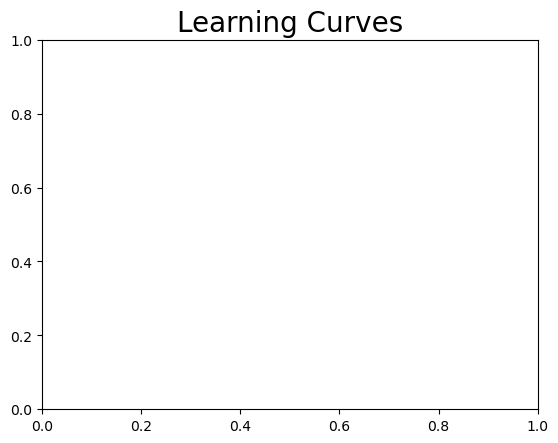

In [25]:
plt.style.use("seaborn-bright")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, n_epochs, n_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, n_epochs, int(n_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

### Sampling process with classifier-free guidance
In order to sample using classifier-free guidance, for each step of the process we need to have 2 elements, one generated conditioned in the desired class (here we want to condition on Hands `=1`) and one using the unconditional class (`=-1`).
Instead using directly the predicted class in every step, we use the unconditional plus the direction vector pointing to the condition that we want (`noise_pred_text - noise_pred_uncond`). The effect of the condition is defined by the `guidance_scale` defining the influence of our direction vector.

100%|███████████████████████████████████████| 1000/1000 [00:12<00:00, 77.06it/s]


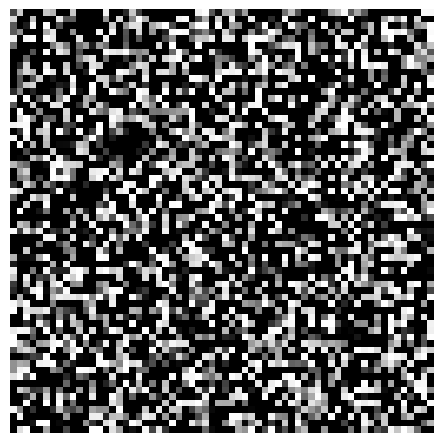

In [27]:
model.eval()
guidance_scale = 7.0
conditioning = torch.cat([-1 * torch.ones(1, 1, 1).float(), torch.ones(1, 1, 1).float()], dim=0).to(device)

noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
progress_bar = tqdm(scheduler.timesteps)
for t in progress_bar:
    with autocast(enabled=True):
        with torch.no_grad():
            noise_input = torch.cat([noise] * 2)
            model_output = model(noise_input, timesteps=torch.Tensor((t,)).to(noise.device))
            noise_pred_uncond, noise_pred_text = model_output.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    noise, _ = scheduler.step(noise_pred, t, noise)

plt.style.use("default")
plt.imshow(noise[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [13]:
if directory is None:
    shutil.rmtree(root_dir)